Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [x] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [x] Engineer at least two new features. (See below for explanation & ideas.)
- [x] Fit a linear regression model with at least two features.
- [x] Get the model's coefficients and intercept.
- [x] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [x] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [x] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [x] Plot best fit plane for your linear regression with 2 features you created.

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '/Users/keila/Documents/Lambda/Units_Git/DS-Unit-2-Linear-Models/data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [3]:
# Libraries for 3D visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Libraries for model buiding
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Wrangle Data

In [4]:
def wrangle(filepath):
    df = pd.read_csv(filepath,
                     dtype = {'description': str},
                    parse_dates = ['created'],
                    index_col = 'created')
    df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]
    return df

In [5]:
# Apply wrangle function to df
df = wrangle(DATA_PATH+'apartments/renthop-nyc.csv')

In [6]:
df.shape

(48817, 33)

In [7]:
df.head()

,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,...,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,
2016-06-24 07:54:24,1.5,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,...,0,0,0,0,0,0,0,0,0,0
2016-06-12 12:19:27,1.0,2,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,...,0,0,0,0,0,0,0,0,0,0
2016-04-17 03:26:41,1.0,1,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,...,0,0,0,0,0,0,0,0,0,0
2016-04-18 02:22:02,1.0,1,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,...,0,0,0,0,0,0,0,0,0,0
2016-04-28 01:32:41,1.0,4,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48817 entries, 2016-06-24 07:54:24 to 2016-04-12 02:48:07
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms             48817 non-null  float64
 1   bedrooms              48817 non-null  int64  
 2   description           47392 non-null  object 
 3   display_address       48684 non-null  object 
 4   latitude              48817 non-null  float64
 5   longitude             48817 non-null  float64
 6   price                 48817 non-null  int64  
 7   street_address        48807 non-null  object 
 8   interest_level        48817 non-null  object 
 9   elevator              48817 non-null  int64  
 10  cats_allowed          48817 non-null  int64  
 11  hardwood_floors       48817 non-null  int64  
 12  dogs_allowed          48817 non-null  int64  
 13  doorman               48817 non-null  int64  
 14  dishwasher            48817 non-nul

## Engineer Features

In [9]:
# Split every string in column, returning a list
split_strs = [str(description).split() for description in df['description']]

# Make that list into an array
split_strs = np.array(split_strs, dtype = object)

# Use vectorize function from numpy
check_len = np.vectorize(len)

# Find length of each element in array
str_lengths = check_len(split_strs)

In [10]:
# Make new feature in df with the array containing lengths of description
df['description_length'] = str_lengths

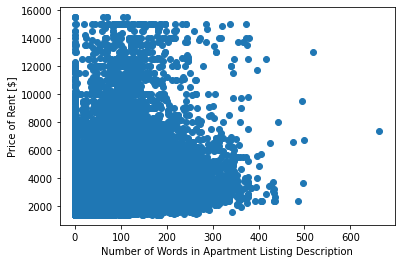

In [11]:
# Visualize relationship between target and description lengths
plt.scatter(df['description_length'], df['price'])
plt.xlabel('Number of Words in Apartment Listing Description')
plt.ylabel('Price of Rent [$]');

In [12]:
# Make feature of ratio bed/bath rooms
df['bed_bath_ratio'] = df['bedrooms']/df['bathrooms']

# Some will be inifinity due to dividing by 0, so I am replacing to NaN
df['bed_bath_ratio'] = df['bed_bath_ratio'].replace([np.inf, -np.inf], np.nan)
# Replacing all NaN to 0
df['bed_bath_ratio'] = df['bed_bath_ratio'].fillna(0)

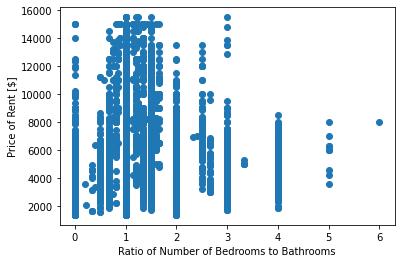

In [13]:
# Visualize relationship between bed/bath ration and price
plt.scatter(df['bed_bath_ratio'], df['price'])
plt.xlabel('Ratio of Number of Bedrooms to Bathrooms')
plt.ylabel('Price of Rent [$]');

In [14]:
# Create feature of total number of rooms in apartment
df['total_rooms'] = df['bedrooms'] + df['bathrooms']

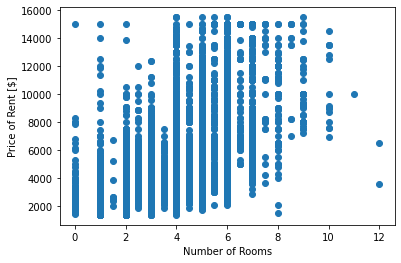

In [15]:
# Visualize relationship between number of rooms and price
plt.scatter(df['total_rooms'], df['price'])
plt.xlabel('Number of Rooms')
plt.ylabel('Price of Rent [$]');

## Split Data

In [16]:
# Split into feature matrix and target vector
X = df[['description_length', 'bed_bath_ratio']]
y = df['price']

In [17]:
# Split into training and test sets
cutoff = '2016-06-01'
mask = df.index < cutoff
X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [18]:
# Make sure everything has correct dimensions
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(31844, 2)
(31844,)
(16973, 2)
(16973,)


## Establish Baseline

In [19]:
print('Mean NYC Apartment Rent:', y_train.mean())
y_pred = [y_train.mean()] * len(y_train)
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Mean NYC Apartment Rent: 3575.604007034292
Baseline MAE: 1201.8811133682555


## Build Model

In [20]:
# 1. Import predictor class, which I did above

# 2. Instantiate model
model = LinearRegression()

# 3. Fit training data to model
model.fit(X_train, y_train)

LinearRegression()

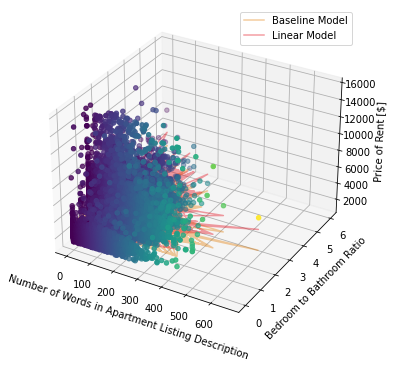

In [32]:
# Set up inital figure and axes
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection = '3d')

# Make colors get consecutively lighter
color = [item for item in X_train['description_length']]

# Plot the data
ax.scatter(xs = X_train['description_length'], ys = X_train['bed_bath_ratio'], zs = y_train, c = color)

# Plot baseline
ax.plot(X_train['description_length'], X_train['bed_bath_ratio'], y_train.mean(), label = 'Baseline Model', 
        color = '#E37F0A', alpha = 0.4)


# Plot linear model
ax.plot(X_train['description_length'], X_train['bed_bath_ratio'], model.predict(X_train), 
        label = 'Linear Model', color = '#E30A1A', alpha = 0.4)


ax.set_xlabel('Number of Words in Apartment Listing Description')
ax.set_ylabel('Bedroom to Bathroom Ratio')
ax.set_zlabel('Price of Rent [$]')
plt.legend()

plt.show()

In [42]:
# Equation of best fit plane
print('Rent price = {:.2f} + description_length*{:.2f} + bed_bath_ratio*{:.2f}'.format(
    model.intercept_, model.coef_[0], model.coef_[1]))

Rent price = 2690.72 + description_length*4.00 + bed_bath_ratio*423.68


## Check Metrics

In [43]:
print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
print('Test MAE:', mean_absolute_error(y_test, model.predict(X_test)))

Training MAE: 1130.4246685606986
Test MAE: 1128.4561479258066


In [44]:
print('Training RSME:', mean_squared_error(y_train, model.predict(X_train), squared = False))
print('Test RSME:', mean_squared_error(y_test, model.predict(X_test), squared = False))

Training RSME: 1704.0943224143607
Test RSME: 1705.4911760046334


In [45]:
print('Traning R^2:', r2_score(y_train, model.predict(X_train)))
print('Test R^2:', r2_score(y_test, model.predict(X_test)))

Traning R^2: 0.06476294065467525
Test R^2: 0.0641311944948858


# Try to get better model

## Split Data

In [33]:
# Get column names to copy-paste
df.columns

Index(['bathrooms', 'bedrooms', 'description', 'display_address', 'latitude',
       'longitude', 'price', 'street_address', 'interest_level', 'elevator',
       'cats_allowed', 'hardwood_floors', 'dogs_allowed', 'doorman',
       'dishwasher', 'no_fee', 'laundry_in_building', 'fitness_center',
       'pre-war', 'laundry_in_unit', 'roof_deck', 'outdoor_space',
       'dining_room', 'high_speed_internet', 'balcony', 'swimming_pool',
       'new_construction', 'terrace', 'exclusive', 'loft', 'garden_patio',
       'wheelchair_access', 'common_outdoor_space', 'description_length',
       'bed_bath_ratio', 'total_rooms'],
      dtype='object')

In [34]:
# Features to use. 27 features total
feats_to_use = ['elevator','cats_allowed', 'hardwood_floors', 'dogs_allowed', 'doorman', 'dishwasher', 
                'no_fee', 'laundry_in_building', 'fitness_center','pre-war', 'laundry_in_unit', 
                'roof_deck', 'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony', 
                'swimming_pool', 'new_construction', 'terrace', 'exclusive', 'loft', 'garden_patio',
                'wheelchair_access', 'common_outdoor_space', 'description_length','bed_bath_ratio', 
                'total_rooms']

# Split data into target matrix and feature vector
X2 = df[feats_to_use]
y2 = df['price']

In [38]:
# Split into training and test sets
cutoff = '2016-06-01'
mask = df.index < cutoff
X2_train, y2_train = X2.loc[mask], y2.loc[mask]
X2_test, y2_test = X2.loc[~mask], y2.loc[~mask]

In [39]:
# Make sure everythign is correct shape
print(X2_train.shape)
print(y2_train.shape)
print(X2_test.shape)
print(y2_test.shape)

(31844, 27)
(31844,)
(16973, 27)
(16973,)


## Establish Baseline

In [50]:
print('Mean NYC Apartment Rent:', y2_train.mean())
y2_pred = [y2_train.mean()] * len(y2_train)
print('Baseline MAE:', mean_absolute_error(y2_train, y2_pred))

Mean NYC Apartment Rent: 3575.604007034292
Baseline MAE: 1201.8811133682555


## Build Model

In [40]:
# Instantiate model
model2 = LinearRegression()

# Fit model to training set using 27 features
model2.fit(X2_train, y2_train)

LinearRegression()

## Check Metrics

In [41]:
print('Training MAE:', mean_absolute_error(y2_train, model2.predict(X2_train)))
print('Test MAE:', mean_absolute_error(y2_test, model2.predict(X2_test)))

Training MAE: 752.6982716619082
Test MAE: 759.9275458116521


In [46]:
print('Training RSME:', mean_squared_error(y2_train, model2.predict(X2_train), squared = False))
print('Test RSME:', mean_squared_error(y2_test, model2.predict(X2_test), squared = False))

Training RSME: 1152.424052806823
Test RSME: 1142.2011214252643


In [47]:
print('Traning R^2:', r2_score(y2_train, model2.predict(X2_train)))
print('Test R^2:', r2_score(y2_test, model2.predict(X2_test)))

Traning R^2: 0.5722804740274918
Test R^2: 0.5802398731053278


Using 27 features returned a much better MAE, RSME, and R^2.